<a href="https://colab.research.google.com/github/anjalii-s/Thesis-2026-/blob/main/final_Lc4_shap_owen_group_banzhaf_myerson_%2Bstatistical_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
"""Complete Game Theory Explainability Comparison"""

# ============================================================
# 1. Install & Imports
# ============================================================
!pip install -q pyspark imbalanced-learn shap lightgbm xgboost seaborn scikit-learn pandas numpy matplotlib networkx statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.utils.class_weight import compute_class_weight
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import shap
import networkx as nx
from scipy import stats
from scipy.spatial.distance import cosine
from sklearn.cluster import AgglomerativeClustering

plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)

# ============================================================
# 2. Load & Preprocess Lending Club Dataset
# ============================================================
print("\n" + "="*80)
print("LOADING AND PREPROCESSING LENDING CLUB DATASET")
print("="*80)

# Load dataset
df = pd.read_csv('LC_50K.csv')

# Clean and prepare
df = df.rename(columns={'Default': 'target'})
columns_to_drop = ['id', 'issue_d', 'zip_code', 'title', 'desc']
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
df = df.drop(columns=existing_columns_to_drop)

# Handle missing values
for column in df.columns:
    if df[column].isnull().sum() > 0:
        if df[column].dtype in ['int64', 'float64']:
            df[column].fillna(df[column].median(), inplace=True)
        else:
            df[column].fillna(df[column].mode()[0], inplace=True)

X = df.drop('target', axis=1)
y = df['target'].astype(int)

print(f"Dataset shape: {df.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")
print(f"Default rate: {(y.mean() * 100):.2f}%")
print(f"Imbalance ratio: {sum(y==0)/sum(y==1):.2f}:1")

# Identify categorical and numeric columns
cat_cols = ['experience_c', 'emp_length', 'purpose', 'home_ownership_n', 'addr_state']
cat_cols = [col for col in cat_cols if col in X.columns]
num_cols = [c for c in X.columns if c not in cat_cols]

print(f"\nCategorical columns ({len(cat_cols)}): {cat_cols}")
print(f"Numeric columns ({len(num_cols)}): {num_cols}")

# Create preprocessing pipeline
cat_categories = [sorted(X[col].dropna().unique().tolist()) for col in cat_cols]
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore',
                         sparse_output=False, categories=cat_categories), cat_cols),
    ('num', StandardScaler(), num_cols)
])

# Fit preprocessor
X_processed = preprocessor.fit_transform(X)
d = X_processed.shape[1]
print(f"\nNumber of processed features: {d}")

# ============================================================
# 3. Models & Sampling Strategies
# ============================================================
models = {
    'RF': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'XGB': xgb.XGBClassifier(n_estimators=100, max_depth=6, random_state=42,
                            eval_metric='logloss', n_jobs=-1),
    'LGB': lgb.LGBMClassifier(n_estimators=100, max_depth=6, random_state=42,
                             verbose=-1, n_jobs=-1)
}

resamplers = {
    'None': None,
    'Under': RandomUnderSampler(random_state=42),
    'CostSensitive': 'cost'
}

# Compute class weights
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weight_dict = {int(cls): float(w) for cls, w in zip(classes, weights)}
print(f"\nClass weights: {class_weight_dict}")

# ============================================================
# 4. Explanation Methods
# ============================================================
def get_shap_reliable(pipe, X_test):
    """Get SHAP values reliably"""
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)

    try:
        explainer = shap.TreeExplainer(clf)
        sv = explainer.shap_values(X_proc)

        if isinstance(sv, list):
            return sv[1]
        elif sv.ndim == 3:
            return sv[:, :, 1]
        else:
            return sv
    except Exception as e:
        print(f"SHAP failed: {e}")
        # Fallback to permutation importance
        from sklearn.inspection import permutation_importance
        res = permutation_importance(clf, X_proc, pipe.predict(X_proc),
                                     n_repeats=3, random_state=42)
        return np.tile(res.importances_mean, (X_proc.shape[0], 1))

def compute_banzhaf(pipe, X_test, n_samples=5, max_instances=5):
    """Compute Banzhaf values"""
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    n_feat = X_proc.shape[1]
    n_inst = min(max_instances, X_proc.shape[0])
    mat = np.zeros((n_inst, n_feat))

    for i in range(n_inst):
        x = X_proc[i:i+1]
        for f in range(n_feat):
            contrib = []
            for _ in range(n_samples):
                # Create random coalition
                coal = np.random.binomial(1, 0.5, n_feat)

                # With feature f
                x_with = x.copy()
                x_with[0, f] = x[0, f] * coal[f]
                p1 = clf.predict_proba(x_with)[0, 1]

                # Without feature f
                x_without = x.copy()
                x_without[0, f] = 0
                p0 = clf.predict_proba(x_without)[0, 1]

                contrib.append(p1 - p0)
            mat[i, f] = np.mean(contrib)

    return mat

# ============================================================
# 5. Myerson Value Functions
# ============================================================
def build_feature_graph(preprocessor, X, threshold=0.25):
    """Build feature graph based on correlation"""
    X_proc = preprocessor.transform(X)
    corr = np.corrcoef(X_proc.T)

    G = nx.Graph()
    d = corr.shape[0]
    G.add_nodes_from(range(d))

    for i in range(d):
        for j in range(i+1, d):
            if abs(corr[i, j]) >= threshold:
                G.add_edge(i, j, weight=corr[i, j])

    return G, corr

def myerson_value(pipe, X_test, G, alpha=0.5, max_instances=50):
    """Compute Myerson values"""
    shap_vals = get_shap_reliable(pipe, X_test)
    shap_mean = shap_vals.mean(axis=0)
    d = len(shap_mean)
    phi = np.zeros(d)

    for i in range(d):
        neighbors = list(G.neighbors(i))
        if len(neighbors) == 0:
            phi[i] = shap_mean[i]
        else:
            neighbor_mean = np.mean([shap_mean[j] for j in neighbors])
            phi[i] = (1 - alpha) * shap_mean[i] + alpha * neighbor_mean

    n_out = min(max_instances, len(X_test))
    return np.tile(phi, (n_out, 1))

# ============================================================
# 6. Owen Value Functions with Multiple Grouping Strategies
# ============================================================
def get_feature_names_out(preprocessor):
    """Get feature names after preprocessing"""
    return preprocessor.get_feature_names_out()

def build_domain_groups(fnames):
    """Build domain-driven groups"""
    groups = {
        "EmploymentIncome": [],
        "LoanCharacteristics": [],
        "Purpose": [],
        "AssetsCollateral": [],
        "Location": []
    }

    for i, name in enumerate(fnames):
        lname = name.lower()
        if any(k in lname for k in ["experience_c", "emp_length", "revenue", "dti_n", "fico_n"]):
            groups["EmploymentIncome"].append(i)
        if "loan_amnt" in lname:
            groups["LoanCharacteristics"].append(i)
        if "purpose" in lname:
            groups["Purpose"].append(i)
        if "home_ownership_n" in lname:
            groups["AssetsCollateral"].append(i)
        if "addr_state" in lname:
            groups["Location"].append(i)

    return {g: v for g, v in groups.items() if len(v) > 0}

def build_data_groups(X_proc, n_groups=6):
    """Build data-driven groups using correlation clustering"""
    try:
        # Clean and compute correlation
        X_proc = np.nan_to_num(X_proc, nan=0.0)
        with np.errstate(invalid='ignore'):
            corr = np.corrcoef(X_proc.T)

        corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)
        np.fill_diagonal(corr, 1.0)
        corr = np.clip(corr, -1.0, 1.0)

        dist = 1 - np.abs(corr)
        dist = np.clip(dist, 0.0, 2.0)

        # Adjust number of groups if needed
        if X_proc.shape[1] < n_groups:
            n_groups = max(2, X_proc.shape[1] // 2)

        clustering = AgglomerativeClustering(
            n_clusters=n_groups,
            metric='precomputed',
            linkage='average'
        )
        labels = clustering.fit_predict(dist)

        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"Cluster_{lab}", []).append(idx)

        return groups, np.abs(corr)
    except Exception as e:
        print(f"Data-driven grouping failed: {e}")
        n_features = X_proc.shape[1]
        return {"Default_Group": list(range(n_features))}, np.eye(n_features)

def build_model_groups(shap_vals, n_groups=6):
    """Build model-driven groups from SHAP values"""
    try:
        shap_vals = np.nan_to_num(shap_vals, nan=0.0)

        if shap_vals.ndim == 1:
            shap_vals = shap_vals.reshape(1, -1)
        elif shap_vals.ndim == 3:
            shap_vals = shap_vals.mean(axis=2) if shap_vals.shape[2] > 1 else shap_vals.squeeze()

        if shap_vals.shape[0] < shap_vals.shape[1]:
            shap_vals = shap_vals.T

        if shap_vals.shape[0] < 2:
            n_features = shap_vals.shape[1] if shap_vals.shape[0] == 1 else shap_vals.shape[0]
            return {"Default_Group": list(range(n_features))}, np.eye(n_features)

        # Compute correlation of SHAP values
        with np.errstate(invalid='ignore'):
            corr = np.corrcoef(shap_vals)

        corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)
        np.fill_diagonal(corr, 1.0)
        corr = np.clip(corr, -1.0, 1.0)

        dist = 1 - np.abs(corr)
        dist = np.clip(dist, 0.0, 2.0)

        n_features = corr.shape[0]
        if n_features < n_groups:
            n_groups = max(2, n_features // 2)

        clustering = AgglomerativeClustering(
            n_clusters=n_groups,
            metric='precomputed',
            linkage='average'
        )
        labels = clustering.fit_predict(dist)

        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"SHAPGroup_{lab}", []).append(idx)

        return groups, np.abs(corr)
    except Exception as e:
        print(f"Model-driven grouping failed: {e}")
        n_features = shap_vals.shape[1] if shap_vals.ndim > 1 else shap_vals.shape[0]
        return {"Default_Group": list(range(n_features))}, np.eye(n_features)

def owen_from_shap(phi, groups):
    """Compute Owen values from SHAP values using groups"""
    d = len(phi)
    out = np.zeros(d)

    for _, feats in groups.items():
        if len(feats) == 0:
            continue

        valid_feats = [f for f in feats if f < d]
        if not valid_feats:
            continue

        total = np.sum(np.abs(phi[valid_feats]))
        per = total / len(valid_feats)

        for f in valid_feats:
            sign = np.sign(phi[f]) if phi[f] != 0 else 1
            out[f] = sign * per

    return out

# ============================================================
# 7. Interpretability Metrics
# ============================================================
def stability_cv(expl_list):
    """Compute stability (coefficient of variation)"""
    if len(expl_list) < 2:
        return 1.0

    try:
        arr = np.stack([np.abs(e) for e in expl_list])
        mean = arr.mean(axis=0) + 1e-8
        std = arr.std(axis=0)
        cv_per_feature = std / mean
        return float(np.mean(cv_per_feature))
    except:
        return 1.0

def kuncheva_index(expl_list, k=5):
    """Compute Kuncheva index for top-K feature consistency"""
    if len(expl_list) < 2:
        return 0.0

    sets = []
    for exp in expl_list:
        try:
            imp = np.abs(exp).mean(axis=0).ravel()
            topk = min(k, len(imp))
            topk_indices = set(np.argsort(imp)[-topk:].tolist())
            sets.append(topk_indices)
        except:
            sets.append(set())

    if len(sets) < 2:
        return 0.0

    ki_values = []
    for i in range(len(sets)):
        for j in range(i+1, len(sets)):
            intersection = len(sets[i] & sets[j])
            if k == d:
                ki = 0.0
            else:
                ki = (intersection - (k**2)/d) / (k - (k**2)/d)
                ki = max(min(ki, 1.0), -1.0)
            ki_values.append(ki)

    return float(np.mean(ki_values)) if ki_values else 0.0

def cosine_directional_consistency(expl_list):
    """Compute cosine similarity between explanation vectors"""
    if len(expl_list) < 2:
        return 1.0

    try:
        # Get mean explanation vectors for each fold
        mean_vecs = [np.mean(np.abs(e), axis=0).ravel() for e in expl_list]

        cos_sims = []
        for i in range(len(mean_vecs)):
            for j in range(i+1, len(mean_vecs)):
                if np.linalg.norm(mean_vecs[i]) == 0 or np.linalg.norm(mean_vecs[j]) == 0:
                    cos_sim = 0.0
                else:
                    cos_sim = 1 - cosine(mean_vecs[i], mean_vecs[j])
                cos_sims.append(cos_sim)

        return float(np.mean(cos_sims)) if cos_sims else 0.0
    except:
        return 0.0

def interpretability_score(cv, kuncheva, cosine_sim, beta=0.3):
    """Compute overall interpretability score"""
    return beta * (1 - cv) + beta * kuncheva + beta * cosine_sim

def normalize(s):
    """Normalize a series to [0,1]"""
    return (s - s.min()) / (s.max() - s.min() + 1e-8)

def tradeoff_metric(auc_series, I_series, alpha=0.5):
    """Compute trade-off metric between AUC and interpretability"""
    return alpha * normalize(auc_series) + (1 - alpha) * normalize(I_series)

# ============================================================
# 8. Main Experiment Loop
# ============================================================
print("\n" + "="*80)
print("STARTING COMPREHENSIVE EXPERIMENT")
print("="*80)

# Build feature graph for Myerson
print("\nBuilding feature graph for Myerson value...")
G_myerson, _ = build_feature_graph(preprocessor, X, threshold=0.25)
print(f"Graph built with {G_myerson.number_of_nodes()} nodes and {G_myerson.number_of_edges()} edges")

# Setup cross-validation
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
all_records = []

# Main experiment loop
for mname, model in models.items():
    for sname, sampler in resamplers.items():
        print(f"\n{'='*60}")
        print(f"Processing: {mname} + {sname}")
        print(f"{'='*60}")

        # Store results for each method
        aucs = []
        shap_runs, banzhaf_runs, myerson_runs = [], [], []
        owen_domain_runs, owen_data_runs, owen_model_runs = [], [], []

        for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
            X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
            y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

            # Create pipeline
            steps = [('prep', preprocessor)]
            if sampler and sampler != 'cost':
                steps.append(('samp', sampler))
            steps.append(('clf', model))
            pipe = ImbPipeline(steps)

            # Apply cost-sensitive learning if needed
            if sname == 'CostSensitive':
                if mname == 'RF':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)
                elif mname == 'XGB':
                    ratio = class_weight_dict[1] / class_weight_dict[0]
                    pipe.named_steps['clf'].set_params(scale_pos_weight=ratio)
                elif mname == 'LGB':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)

            # Train model
            pipe.fit(X_tr, y_tr)

            # Compute AUC
            auc = roc_auc_score(y_te, pipe.predict_proba(X_te)[:, 1])
            aucs.append(auc)
            print(f"  Fold {fold}: AUC = {auc:.4f}")

            # Sample for explanations
            X_sample = X_te.sample(n=min(50, len(X_te)), random_state=42)

            # 1. SHAP
            try:
                shap_vals = get_shap_reliable(pipe, X_sample)
                shap_runs.append(shap_vals)
            except Exception as e:
                print(f"    SHAP failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                shap_runs.append(np.zeros((min(50, len(X_sample)), n_features)))

            # 2. Banzhaf
            try:
                banzhaf_vals = compute_banzhaf(pipe, X_sample)
                banzhaf_runs.append(banzhaf_vals)
            except Exception as e:
                print(f"    Banzhaf failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                banzhaf_runs.append(np.zeros((min(5, len(X_sample)), n_features)))

            # 3. Myerson
            try:
                myerson_vals = myerson_value(pipe, X_sample, G_myerson)
                myerson_runs.append(myerson_vals)
            except Exception as e:
                print(f"    Myerson failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                myerson_runs.append(np.zeros((min(50, len(X_sample)), n_features)))

            # 4. Owen with different grouping strategies
            try:
                # Get SHAP values for Owen
                shap_vals_owen = get_shap_reliable(pipe, X_sample)
                phi = np.mean(shap_vals_owen, axis=0)

                # Get feature names
                fnames = get_feature_names_out(preprocessor)

                # Domain-driven groups
                dom_groups = build_domain_groups(fnames)
                owen_domain_vals = np.tile(owen_from_shap(phi, dom_groups),
                                          (min(50, len(X_sample)), 1))
                owen_domain_runs.append(owen_domain_vals)

                # Data-driven groups
                X_tr_proc = pipe.named_steps['prep'].transform(X_tr)
                data_groups, _ = build_data_groups(X_tr_proc)
                owen_data_vals = np.tile(owen_from_shap(phi, data_groups),
                                        (min(50, len(X_sample)), 1))
                owen_data_runs.append(owen_data_vals)

                # Model-driven groups
                X_tr_sample = X_tr.sample(n=min(100, len(X_tr)), random_state=42)
                shap_tr = get_shap_reliable(pipe, X_tr_sample)
                model_groups, _ = build_model_groups(shap_tr)
                owen_model_vals = np.tile(owen_from_shap(phi, model_groups),
                                         (min(50, len(X_sample)), 1))
                owen_model_runs.append(owen_model_vals)

            except Exception as e:
                print(f"    Owen failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                zeros = np.zeros((min(50, len(X_sample)), n_features))
                owen_domain_runs.append(zeros)
                owen_data_runs.append(zeros)
                owen_model_runs.append(zeros)

        # Compute average AUC
        auc_mean = np.mean(aucs)

        # Process results for each method
        method_runs = [
            ('SHAP', shap_runs),
            ('Banzhaf', banzhaf_runs),
            ('Myerson', myerson_runs),
            ('Owen_Domain', owen_domain_runs),
            ('Owen_Data', owen_data_runs),
            ('Owen_Model', owen_model_runs)
        ]

        for method_name, runs in method_runs:
            if runs:  # Only process if we have results
                cv_val = stability_cv(runs)
                kun_val = kuncheva_index(runs, k=5)
                cos_val = cosine_directional_consistency(runs)
                I_val = interpretability_score(cv_val, kun_val, cos_val)

                # Extract grouping type for Owen methods
                if method_name.startswith('Owen_'):
                    grouping = method_name.split('_')[1]
                    method_base = 'Owen'
                else:
                    grouping = 'None'
                    method_base = method_name

                all_records.append({
                    'Model': mname,
                    'Sampler': sname,
                    'Method': method_base,
                    'Grouping': grouping,
                    'AUC': auc_mean,
                    'CV': cv_val,
                    'Stability': 1 - cv_val,
                    'Kuncheva': kun_val,
                    'Cosine': cos_val,
                    'I': I_val
                })

# ============================================================
# 9. Process and Save Results
# ============================================================
print("\n" + "="*80)
print("PROCESSING RESULTS")
print("="*80)

if all_records:
    metrics = pd.DataFrame(all_records)
    metrics['T(α=0.5)'] = tradeoff_metric(metrics['AUC'], metrics['I'])

    print("\nComplete Results:")
    print(metrics.round(4).to_string(index=False))

    # Save results
    metrics.to_csv('complete_results.csv', index=False)
    print("\n✓ Results saved to: complete_results.csv")

    # Summary by method
    print("\n" + "="*80)
    print("SUMMARY BY EXPLANATION METHOD")
    print("="*80)

    summary_method = metrics.groupby('Method').agg({
        'AUC': 'mean',
        'Stability': 'mean',
        'Kuncheva': 'mean',
        'Cosine': 'mean',
        'I': 'mean',
        'T(α=0.5)': 'mean'
    }).round(4)
    print(summary_method)

    # Summary for Owen grouping strategies
    owen_data = metrics[metrics['Method'] == 'Owen']
    if not owen_data.empty:
        print("\n" + "="*80)
        print("OWEN GROUPING STRATEGIES COMPARISON")
        print("="*80)

        owen_summary = owen_data.groupby('Grouping').agg({
            'AUC': 'mean',
            'Stability': 'mean',
            'Kuncheva': 'mean',
            'Cosine': 'mean',
            'I': 'mean',
            'T(α=0.5)': 'mean'
        }).round(4)
        print(owen_summary)

    # Best configurations
    print("\n" + "="*80)
    print("TOP 5 OVERALL CONFIGURATIONS")
    print("="*80)

    top5 = metrics.nlargest(5, 'T(α=0.5)')[['Model', 'Sampler', 'Method', 'Grouping',
                                           'AUC', 'I', 'T(α=0.5)']]
    print(top5.round(4).to_string(index=False))

else:
    print("No results generated!")
    metrics = pd.DataFrame()

# ============================================================
# 10. Statistical Validation
# ============================================================
if not metrics.empty:
    print("\n" + "="*80)
    print("STATISTICAL VALIDATION")
    print("="*80)

    # Prepare data for statistical tests
    methods = ['SHAP', 'Banzhaf', 'Myerson', 'Owen']

    # 10.1 Friedman Test for each metric
    print("\nFriedman Test (Overall Method Differences):")
    for metric in ['AUC', 'I', 'T(α=0.5)', 'Kuncheva', 'Cosine']:
        print(f"\n=== {metric} ===")

        # Create pivot table for Friedman test
        pivoted = metrics.pivot_table(values=metric, index=['Model', 'Sampler', 'Grouping'],
                                     columns='Method', aggfunc='first')

        # Keep only methods with data for all configurations
        methods_with_data = [m for m in methods if m in pivoted.columns]
        if len(methods_with_data) >= 2:
            data_for_test = [pivoted[m].dropna().values for m in methods_with_data]

            if len(data_for_test[0]) >= 2:
                stat, p = stats.friedmanchisquare(*data_for_test)

                # Compute Kendall's W
                n = len(data_for_test[0])
                k = len(methods_with_data)
                kendall_w = stat / (n * (k - 1))

                print(f"Methods: {methods_with_data}")
                print(f"Friedman χ² = {stat:.3f}, p = {p:.4f}")
                print(f"Kendall's W = {kendall_w:.4f}")
                print(f"Significant: {'Yes' if p < 0.05 else 'No'}")
            else:
                print(f"Insufficient data for {metric}")
        else:
            print(f"Insufficient methods for {metric}")

    # 10.2 Pairwise Wilcoxon Tests
    print("\n" + "="*80)
    print("PAIRWISE WILCOXON TESTS")
    print("="*80)

    pairs = [('SHAP', 'Banzhaf'), ('SHAP', 'Myerson'), ('SHAP', 'Owen'),
             ('Banzhaf', 'Myerson'), ('Banzhaf', 'Owen'), ('Myerson', 'Owen')]

    for metric in ['T(α=0.5)', 'I', 'Kuncheva']:
        print(f"\n=== {metric} ===")

        for m1, m2 in pairs:
            data1 = metrics[metrics['Method'] == m1][metric].values
            data2 = metrics[metrics['Method'] == m2][metric].values

            # Ensure equal lengths
            min_len = min(len(data1), len(data2))
            if min_len >= 2:
                data1 = data1[:min_len]
                data2 = data2[:min_len]

                stat, p = stats.wilcoxon(data1, data2)
                print(f"{m1} vs {m2}: W = {stat:.1f}, p = {p:.4f} ({'*' if p < 0.05 else ''})")
            else:
                print(f"{m1} vs {m2}: Insufficient data")

    # 10.3 Effect Sizes (Cliff's Delta)
    print("\n" + "="*80)
    print("EFFECT SIZES (Cliff's Delta)")
    print("="*80)

    def cliffs_delta(x, y):
        """Compute Cliff's delta effect size"""
        comparisons = [1 if xi > yj else -1 if xi < yj else 0
                      for xi in x for yj in y]
        return sum(comparisons) / len(comparisons)

    def interpret_delta(delta):
        """Interpret Cliff's delta magnitude"""
        abs_delta = abs(delta)
        if abs_delta < 0.147:
            return "negligible"
        elif abs_delta < 0.33:
            return "small"
        elif abs_delta < 0.474:
            return "medium"
        else:
            return "large"

    for metric in ['T(α=0.5)', 'I']:
        print(f"\n=== {metric} ===")

        for m1, m2 in pairs:
            data1 = metrics[metrics['Method'] == m1][metric].values
            data2 = metrics[metrics['Method'] == m2][metric].values

            min_len = min(len(data1), len(data2))
            if min_len >= 2:
                data1 = data1[:min_len]
                data2 = data2[:min_len]

                delta = cliffs_delta(data1, data2)
                magnitude = interpret_delta(delta)
                print(f"{m1} vs {m2}: δ = {delta:.4f} ({magnitude})")

    # 10.4 Correlation Analysis
    print("\n" + "="*80)
    print("CORRELATION ANALYSIS")
    print("="*80)

    # Correlation between AUC and interpretability
    rho_auc_i, p_auc_i = stats.spearmanr(metrics['AUC'], metrics['I'])
    print(f"AUC vs I: ρ = {rho_auc_i:.4f}, p = {p_auc_i:.4f}")

    # Correlation between stability metrics
    rho_stab_kun, p_stab_kun = stats.spearmanr(metrics['Stability'], metrics['Kuncheva'])
    print(f"Stability vs Kuncheva: ρ = {rho_stab_kun:.4f}, p = {p_stab_kun:.4f}")

    rho_stab_cos, p_stab_cos = stats.spearmanr(metrics['Stability'], metrics['Cosine'])
    print(f"Stability vs Cosine: ρ = {rho_stab_cos:.4f}, p = {p_stab_cos:.4f}")

    # 10.5 Bootstrap Confidence Intervals
    print("\n" + "="*80)
    print("BOOTSTRAP 95% CONFIDENCE INTERVALS")
    print("="*80)

    def bootstrap_ci(data, n_bootstrap=1000):
        """Compute bootstrap confidence interval"""
        if len(data) < 2:
            return np.nan, np.nan

        bootstrap_means = []
        for _ in range(n_bootstrap):
            sample = np.random.choice(data, size=len(data), replace=True)
            bootstrap_means.append(np.mean(sample))

        lower = np.percentile(bootstrap_means, 2.5)
        upper = np.percentile(bootstrap_means, 97.5)
        return lower, upper

    for metric in ['T(α=0.5)', 'I', 'AUC']:
        print(f"\n=== {metric} ===")

        for method in methods:
            if method in metrics['Method'].values:
                data = metrics[metrics['Method'] == method][metric].values
                if len(data) >= 2:
                    lower, upper = bootstrap_ci(data)
                    mean_val = np.mean(data)
                    print(f"{method}: {mean_val:.4f} [{lower:.4f}, {upper:.4f}]")

# ============================================================
# 11. Visualization
# ============================================================
if not metrics.empty:
    print("\n" + "="*80)
    print("GENERATING VISUALIZATIONS")
    print("="*80)

    # Set style
    plt.style.use('seaborn-v0_8-darkgrid')

    # 1. Trade-off by Method
    plt.figure(figsize=(12, 6))

    method_avg = metrics.groupby('Method')['T(α=0.5)'].mean().sort_values(ascending=False)
    colors = ['#4C78A8', '#F58518', '#E45756', '#72B7B2']

    bars = plt.bar(method_avg.index, method_avg.values, color=colors, edgecolor='black')
    plt.bar_label(bars, fmt='%.3f', padding=3)
    plt.ylabel('Trade-off T(α=0.5)')
    plt.title('Average Trade-off by Explanation Method')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('tradeoff_by_method.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 2. Interpretability Components
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Stability
    stability_avg = metrics.groupby('Method')['Stability'].mean()
    axes[0].bar(stability_avg.index, stability_avg.values, color=colors, edgecolor='black')
    axes[0].set_title('Stability (1 - CV)')
    axes[0].set_ylabel('Score')
    axes[0].set_ylim(0, 1)
    axes[0].grid(axis='y', alpha=0.3)

    # Kuncheva
    kuncheva_avg = metrics.groupby('Method')['Kuncheva'].mean()
    axes[1].bar(kuncheva_avg.index, kuncheva_avg.values, color=colors, edgecolor='black')
    axes[1].set_title('Kuncheva Index')
    axes[1].set_ylabel('Score')
    axes[1].set_ylim(-0.2, 1.2)
    axes[1].grid(axis='y', alpha=0.3)

    # Cosine
    cosine_avg = metrics.groupby('Method')['Cosine'].mean()
    axes[2].bar(cosine_avg.index, cosine_avg.values, color=colors, edgecolor='black')
    axes[2].set_title('Cosine Similarity')
    axes[2].set_ylabel('Score')
    axes[2].set_ylim(0, 1)
    axes[2].grid(axis='y', alpha=0.3)

    plt.suptitle('Interpretability Components by Method', fontsize=14)
    plt.tight_layout()
    plt.savefig('interpretability_components.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 3. Owen Grouping Comparison
    if 'Owen' in metrics['Method'].values:
        owen_data = metrics[metrics['Method'] == 'Owen']
        if not owen_data.empty:
            plt.figure(figsize=(10, 6))

            grouping_avg = owen_data.groupby('Grouping')['T(α=0.5)'].mean()
            grouping_colors = ['#4C78A8', '#F58518', '#E45756']

            bars = plt.bar(grouping_avg.index, grouping_avg.values,
                          color=grouping_colors, edgecolor='black')
            plt.bar_label(bars, fmt='%.3f', padding=3)
            plt.ylabel('Trade-off T(α=0.5)')
            plt.title('Owen Value: Performance by Grouping Strategy')
            plt.grid(axis='y', alpha=0.3)
            plt.tight_layout()
            plt.savefig('owen_grouping_comparison.png', dpi=300, bbox_inches='tight')
            plt.show()

    # 4. Scatter: AUC vs Interpretability
    plt.figure(figsize=(10, 6))

    colors_dict = {'SHAP': '#4C78A8', 'Banzhaf': '#F58518',
                   'Myerson': '#E45756', 'Owen': '#72B7B2'}

    for method in methods:
        if method in metrics['Method'].values:
            method_data = metrics[metrics['Method'] == method]
            plt.scatter(method_data['AUC'], method_data['I'],
                       s=80, alpha=0.7, label=method,
                       color=colors_dict.get(method, 'gray'),
                       edgecolors='black', linewidth=0.5)

    plt.xlabel('AUC')
    plt.ylabel('Interpretability (I)')
    plt.title('AUC vs Interpretability by Method')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('auc_vs_interpretability.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 5. Model Comparison
    plt.figure(figsize=(12, 6))

    models_compare = ['RF', 'XGB', 'LGB']
    model_colors = ['#4C78A8', '#F58518', '#E45756']

    model_data = []
    for model in models_compare:
        if model in metrics['Model'].values:
            model_metrics = metrics[metrics['Model'] == model]
            model_data.append({
                'Model': model,
                'AUC': model_metrics['AUC'].mean(),
                'I': model_metrics['I'].mean(),
                'T(α=0.5)': model_metrics['T(α=0.5)'].mean()
            })

    if model_data:
        model_df = pd.DataFrame(model_data)
        x = np.arange(len(model_df))
        width = 0.25

        plt.bar(x - width, model_df['AUC'], width, label='AUC', color=model_colors[0])
        plt.bar(x, model_df['I'], width, label='Interpretability', color=model_colors[1])
        plt.bar(x + width, model_df['T(α=0.5)'], width, label='Trade-off', color=model_colors[2])

        plt.xlabel('Model')
        plt.ylabel('Score')
        plt.title('Performance by Model Type')
        plt.xticks(x, model_df['Model'])
        plt.legend()
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

    print("\nVisualizations saved:")
    print("1. tradeoff_by_method.png")
    print("2. interpretability_components.png")
    print("3. owen_grouping_comparison.png")
    print("4. auc_vs_interpretability.png")
    print("5. model_comparison.png")

# ============================================================
# 12. Final Summary
# ============================================================
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

if not metrics.empty:
    # Best overall configuration
    best_overall = metrics.loc[metrics['T(α=0.5)'].idxmax()]
    print(f"\n🏆 BEST OVERALL CONFIGURATION:")
    print(f"   Model: {best_overall['Model']}")
    print(f"   Sampler: {best_overall['Sampler']}")
    print(f"   Method: {best_overall['Method']}")
    print(f"   Grouping: {best_overall['Grouping']}")
    print(f"   AUC: {best_overall['AUC']:.4f}")
    print(f"   Interpretability: {best_overall['I']:.4f}")
    print(f"   Trade-off: {best_overall['T(α=0.5)']:.4f}")

    # Best by method
    print(f"\n🔍 BEST BY METHOD:")
    for method in methods:
        if method in metrics['Method'].values:
            method_data = metrics[metrics['Method'] == method]
            best_method = method_data.loc[method_data['T(α=0.5)'].idxmax()]
            print(f"   {method}: {best_method['Model']}+{best_method['Sampler']} "
                  f"(T={best_method['T(α=0.5)']:.4f})")

    # Method rankings
    print(f"\n📊 METHOD RANKINGS:")
    method_ranks = metrics.groupby('Method')['T(α=0.5)'].mean().sort_values(ascending=False)
    for rank, (method, score) in enumerate(method_ranks.items(), 1):
        print(f"   {rank}. {method}: {score:.4f}")

    # Dataset statistics
    print(f"\n📈 DATASET STATISTICS:")
    print(f"   Total samples: {len(df)}")
    print(f"   Default rate: {(y.mean() * 100):.2f}%")
    print(f"   Features: {X.shape[1]} ({len(cat_cols)} categorical, {len(num_cols)} numerical)")
    print(f"   Processed features: {d}")

    # Performance summary
    print(f"\n🎯 PERFORMANCE SUMMARY:")
    print(f"   Best AUC: {metrics['AUC'].max():.4f}")
    print(f"   Best Interpretability: {metrics['I'].max():.4f}")
    print(f"   Best Trade-off: {metrics['T(α=0.5)'].max():.4f}")

print("\n" + "="*80)
print("EXPERIMENT COMPLETE!")
print("="*80)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.4/455.4 MB 922.4 kB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 120.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 143.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.3/233.3 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.0/203.0 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.8/289.8 MB 1.2 MB/s eta 0:00:00

LOADING AND PREPROCESSING LENDING CLUB DATASET
Dataset shape: (50000, 10)
Target distribution: {0: 48000, 1: 2000}
Default rate: 4.00%
Imbalance

ValueError: Array shapes are incompatible for broadcasting.

In [2]:
# ============================================================
# 10. Statistical Validation (FIXED VERSION)
# ============================================================
if not metrics.empty:
    print("\n" + "="*80)
    print("STATISTICAL VALIDATION (FIXED)")
    print("="*80)

    # Prepare clean data for statistical tests
    # Remove rows with NaN values in key metrics
    clean_metrics = metrics.dropna(subset=['AUC', 'I', 'T(α=0.5)', 'Kuncheva', 'Cosine', 'Stability'])

    # 10.1 Kruskal-Wallis Tests (alternative to Friedman for unequal sample sizes)
    print("\nKruskal-Wallis Test (Overall Method Differences):")

    def perform_kruskal_test(data, metric, group_col='Method'):
        """Perform Kruskal-Wallis test for multiple groups"""
        groups = [data[data[group_col] == m][metric].values
                 for m in data[group_col].unique()]
        groups = [g for g in groups if len(g) > 1]

        if len(groups) >= 2:
            stat, p = stats.kruskal(*groups)
            return stat, p, groups
        return None, None, groups

    for metric in ['T(α=0.5)', 'I', 'AUC', 'Kuncheva', 'Cosine', 'Stability']:
        print(f"\n=== {metric} ===")
        stat, p, groups = perform_kruskal_test(clean_metrics, metric)

        if stat is not None:
            print(f"Kruskal-Wallis H = {stat:.3f}, p = {p:.4f}")
            print(f"Significant difference: {'YES' if p < 0.05 else 'NO'}")
            print(f"Number of groups: {len(groups)}, Sample sizes: {[len(g) for g in groups]}")
        else:
            print("Insufficient data for statistical test")

    # 10.2 Pairwise Mann-Whitney U Tests with Bonferroni correction
    print("\n" + "="*80)
    print("PAIRWISE MANN-WHITNEY U TESTS (Bonferroni Corrected)")
    print("="*80)

    methods = clean_metrics['Method'].unique()
    pairs = [(m1, m2) for i, m1 in enumerate(methods) for j, m2 in enumerate(methods) if i < j]

    for metric in ['T(α=0.5)', 'I', 'Kuncheva']:
        print(f"\n=== {metric} ===")

        results = []
        for m1, m2 in pairs:
            data1 = clean_metrics[clean_metrics['Method'] == m1][metric].values
            data2 = clean_metrics[clean_metrics['Method'] == m2][metric].values

            if len(data1) > 1 and len(data2) > 1:
                stat, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
                results.append({
                    'comparison': f"{m1} vs {m2}",
                    'stat': stat,
                    'p': p,
                    'mean1': np.mean(data1),
                    'mean2': np.mean(data2)
                })

        # Apply Bonferroni correction
        n_comparisons = len(results)
        bonferroni_alpha = 0.05 / n_comparisons if n_comparisons > 0 else 0.05

        for res in results:
            significant = res['p'] < bonferroni_alpha
            sig_mark = " ***" if significant else ""
            print(f"{res['comparison']}: U = {res['stat']:.0f}, p = {res['p']:.4f}, "
                  f"Δμ = {res['mean1'] - res['mean2']:.4f}{sig_mark}")

    # 10.3 Effect Sizes (Cliff's Delta)
    print("\n" + "="*80)
    print("EFFECT SIZES (Cliff's Delta)")
    print("="*80)

    def cliffs_delta(x, y):
        """Compute Cliff's delta effect size"""
        comparisons = [1 if xi > yj else -1 if xi < yj else 0
                      for xi in x for yj in y]
        return sum(comparisons) / len(comparisons)

    def interpret_delta(delta):
        """Interpret Cliff's delta magnitude"""
        abs_delta = abs(delta)
        if abs_delta < 0.147:
            return "negligible"
        elif abs_delta < 0.33:
            return "small"
        elif abs_delta < 0.474:
            return "medium"
        else:
            return "large"

    for metric in ['T(α=0.5)', 'I']:
        print(f"\n=== {metric} ===")

        for m1, m2 in pairs:
            data1 = clean_metrics[clean_metrics['Method'] == m1][metric].values
            data2 = clean_metrics[clean_metrics['Method'] == m2][metric].values

            if len(data1) > 1 and len(data2) > 1:
                delta = cliffs_delta(data1, data2)
                magnitude = interpret_delta(delta)
                print(f"{m1} vs {m2}: δ = {delta:.4f} ({magnitude})")

    # 10.4 Correlation Analysis
    print("\n" + "="*80)
    print("CORRELATION ANALYSIS (Spearman's ρ)")
    print("="*80)

    # Overall correlations
    correlations = [
        ('AUC vs I', clean_metrics['AUC'], clean_metrics['I']),
        ('Stability vs Kuncheva', clean_metrics['Stability'], clean_metrics['Kuncheva']),
        ('Stability vs Cosine', clean_metrics['Stability'], clean_metrics['Cosine']),
        ('Kuncheva vs Cosine', clean_metrics['Kuncheva'], clean_metrics['Cosine']),
        ('AUC vs T(α=0.5)', clean_metrics['AUC'], clean_metrics['T(α=0.5)']),
        ('I vs T(α=0.5)', clean_metrics['I'], clean_metrics['T(α=0.5)'])
    ]

    for name, x, y in correlations:
        if len(x) > 1 and len(y) > 1:
            rho, p = stats.spearmanr(x, y)
            sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
            print(f"{name}: ρ = {rho:.4f}, p = {p:.4f} {sig}")

    # Method-specific correlations
    print("\nMethod-specific correlations (AUC vs I):")
    for method in methods:
        method_data = clean_metrics[clean_metrics['Method'] == method]
        if len(method_data) > 2:
            rho, p = stats.spearmanr(method_data['AUC'], method_data['I'])
            sig = "*" if p < 0.05 else ""
            print(f"  {method}: ρ = {rho:.4f}, p = {p:.4f} {sig}")

    # 10.5 Bootstrap Confidence Intervals (95%)
    print("\n" + "="*80)
    print("BOOTSTRAP 95% CONFIDENCE INTERVALS (1000 resamples)")
    print("="*80)

    def bootstrap_ci(data, n_bootstrap=1000, confidence=0.95):
        """Compute bootstrap confidence interval"""
        if len(data) < 2:
            return np.nan, np.nan, np.nan

        bootstrap_means = []
        for _ in range(n_bootstrap):
            sample = np.random.choice(data, size=len(data), replace=True)
            bootstrap_means.append(np.mean(sample))

        lower = np.percentile(bootstrap_means, (1-confidence)/2 * 100)
        upper = np.percentile(bootstrap_means, (1 - (1-confidence)/2) * 100)
        mean_val = np.mean(data)

        return mean_val, lower, upper

    for metric in ['T(α=0.5)', 'I', 'AUC']:
        print(f"\n=== {metric} ===")

        # Overall CI
        overall_mean, overall_lower, overall_upper = bootstrap_ci(clean_metrics[metric].values)
        print(f"Overall: {overall_mean:.4f} [{overall_lower:.4f}, {overall_upper:.4f}]")

        # Method-specific CIs
        for method in sorted(methods):
            method_data = clean_metrics[clean_metrics['Method'] == method][metric].values
            if len(method_data) >= 2:
                mean_val, lower, upper = bootstrap_ci(method_data)
                print(f"  {method}: {mean_val:.4f} [{lower:.4f}, {upper:.4f}]")

    # 10.6 Shapiro-Wilk Normality Tests
    print("\n" + "="*80)
    print("SHAPIRO-WILK NORMALITY TESTS")
    print("="*80)

    for metric in ['T(α=0.5)', 'I', 'AUC', 'Kuncheva']:
        print(f"\n=== {metric} ===")

        for method in methods:
            data = clean_metrics[clean_metrics['Method'] == method][metric].values
            if len(data) >= 3 and len(data) <= 5000:  # Shapiro-Wilk works for 3-5000 samples
                stat, p = stats.shapiro(data)
                normal = "normal" if p > 0.05 else "NOT normal"
                print(f"  {method}: W = {stat:.4f}, p = {p:.4f} ({normal})")

    # 10.7 Levene's Test for Equal Variances
    print("\n" + "="*80)
    print("LEVENE'S TEST FOR EQUAL VARIANCES")
    print("="*80)

    for metric in ['T(α=0.5)', 'I', 'AUC']:
        print(f"\n=== {metric} ===")

        groups = [clean_metrics[clean_metrics['Method'] == m][metric].values
                 for m in methods]
        groups = [g for g in groups if len(g) > 1]

        if len(groups) >= 2:
            stat, p = stats.levene(*groups)
            equal = "equal" if p > 0.05 else "unequal"
            print(f"Levene's test: W = {stat:.4f}, p = {p:.4f} ({equal} variances)")

    # 10.8 Model Comparison Statistics
    print("\n" + "="*80)
    print("MODEL COMPARISON STATISTICS")
    print("="*80)

    models_list = ['RF', 'XGB', 'LGB']
    for metric in ['T(α=0.5)', 'I', 'AUC']:
        print(f"\n=== {metric} by Model ===")

        model_groups = [clean_metrics[clean_metrics['Model'] == m][metric].values
                       for m in models_list if m in clean_metrics['Model'].values]
        model_groups = [g for g in model_groups if len(g) > 1]

        if len(model_groups) >= 2:
            stat, p = stats.kruskal(*model_groups)
            print(f"Kruskal-Wallis across models: H = {stat:.3f}, p = {p:.4f}")

            # Pairwise comparisons
            model_pairs = [(models_list[i], models_list[j])
                          for i in range(len(models_list))
                          for j in range(i+1, len(models_list))]

            for m1, m2 in model_pairs:
                if m1 in clean_metrics['Model'].values and m2 in clean_metrics['Model'].values:
                    data1 = clean_metrics[clean_metrics['Model'] == m1][metric].values
                    data2 = clean_metrics[clean_metrics['Model'] == m2][metric].values

                    if len(data1) > 1 and len(data2) > 1:
                        stat_u, p_u = stats.mannwhitneyu(data1, data2, alternative='two-sided')
                        print(f"  {m1} vs {m2}: U = {stat_u:.0f}, p = {p_u:.4f}")

    # 10.9 Owen Grouping Strategy Comparison
    if 'Owen' in clean_metrics['Method'].values:
        owen_data = clean_metrics[clean_metrics['Method'] == 'Owen']
        if 'Grouping' in owen_data.columns and len(owen_data['Grouping'].unique()) > 1:
            print("\n" + "="*80)
            print("OWEN GROUPING STRATEGY COMPARISON")
            print("="*80)

            groupings = owen_data['Grouping'].unique()
            for metric in ['T(α=0.5)', 'I', 'Kuncheva']:
                print(f"\n=== {metric} by Owen Grouping ===")

                groups = [owen_data[owen_data['Grouping'] == g][metric].values
                         for g in groupings]
                groups = [g for g in groups if len(g) > 1]

                if len(groups) >= 2:
                    stat, p = stats.kruskal(*groups)
                    print(f"Kruskal-Wallis: H = {stat:.3f}, p = {p:.4f}")

                    # Mean values for each grouping
                    for grouping in groupings:
                        group_data = owen_data[owen_data['Grouping'] == grouping][metric].values
                        if len(group_data) > 0:
                            mean_val = np.mean(group_data)
                            print(f"  {grouping}: mean = {mean_val:.4f}")

    # 10.10 Statistical Power Analysis
    print("\n" + "="*80)
    print("STATISTICAL POWER ANALYSIS")
    print("="*80)

    # Calculate effect sizes for power analysis
    effect_sizes = []
    for m1, m2 in pairs:
        if m1 in clean_metrics['Method'].values and m2 in clean_metrics['Method'].values:
            data1 = clean_metrics[clean_metrics['Method'] == m1]['T(α=0.5)'].values
            data2 = clean_metrics[clean_metrics['Method'] == m2]['T(α=0.5)'].values

            if len(data1) > 1 and len(data2) > 1:
                # Cohen's d for effect size
                pooled_std = np.sqrt((np.std(data1, ddof=1)**2 + np.std(data2, ddof=1)**2) / 2)
                if pooled_std > 0:
                    d = abs(np.mean(data1) - np.mean(data2)) / pooled_std
                    effect_sizes.append(d)

    if effect_sizes:
        avg_effect_size = np.mean(effect_sizes)
        print(f"Average effect size (Cohen's d): {avg_effect_size:.3f}")
        print("Interpretation:")
        if avg_effect_size < 0.2:
            print("  Very small effect")
        elif avg_effect_size < 0.5:
            print("  Small effect")
        elif avg_effect_size < 0.8:
            print("  Medium effect")
        else:
            print("  Large effect")

        # Power calculation for typical sample size
        sample_size = len(clean_metrics) // len(methods) if len(methods) > 0 else 0
        if sample_size > 0:
            # Assuming alpha=0.05, two-tailed test
            power = 0.8  # Target power
            print(f"\nFor sample size ~{sample_size} per group and α=0.05:")
            print(f"  Detectable effect size (d) at 80% power: ~0.5-0.8")
            print(f"  Your average effect size: {avg_effect_size:.3f}")
            if avg_effect_size > 0.5:
                print("  ✓ Adequate power to detect effects")
            else:
                print("  ⚠ Power may be limited for small effects")


STATISTICAL VALIDATION (FIXED)

Kruskal-Wallis Test (Overall Method Differences):

=== T(α=0.5) ===
Kruskal-Wallis H = 6.069, p = 0.1083
Significant difference: NO
Number of groups: 4, Sample sizes: [9, 9, 9, 27]

=== I ===
Kruskal-Wallis H = 15.866, p = 0.0012
Significant difference: YES
Number of groups: 4, Sample sizes: [9, 9, 9, 27]

=== AUC ===
Kruskal-Wallis H = 0.000, p = 1.0000
Significant difference: NO
Number of groups: 4, Sample sizes: [9, 9, 9, 27]

=== Kuncheva ===
Kruskal-Wallis H = 7.483, p = 0.0580
Significant difference: NO
Number of groups: 4, Sample sizes: [9, 9, 9, 27]

=== Cosine ===
Kruskal-Wallis H = 30.898, p = 0.0000
Significant difference: YES
Number of groups: 4, Sample sizes: [9, 9, 9, 27]

=== Stability ===
Kruskal-Wallis H = 35.563, p = 0.0000
Significant difference: YES
Number of groups: 4, Sample sizes: [9, 9, 9, 27]

PAIRWISE MANN-WHITNEY U TESTS (Bonferroni Corrected)

=== T(α=0.5) ===
SHAP vs Banzhaf: U = 43, p = 0.8598, Δμ = 0.0186
SHAP vs Myerson: 

Loaded 54 results

1. Generating Trade-off Score by Method...


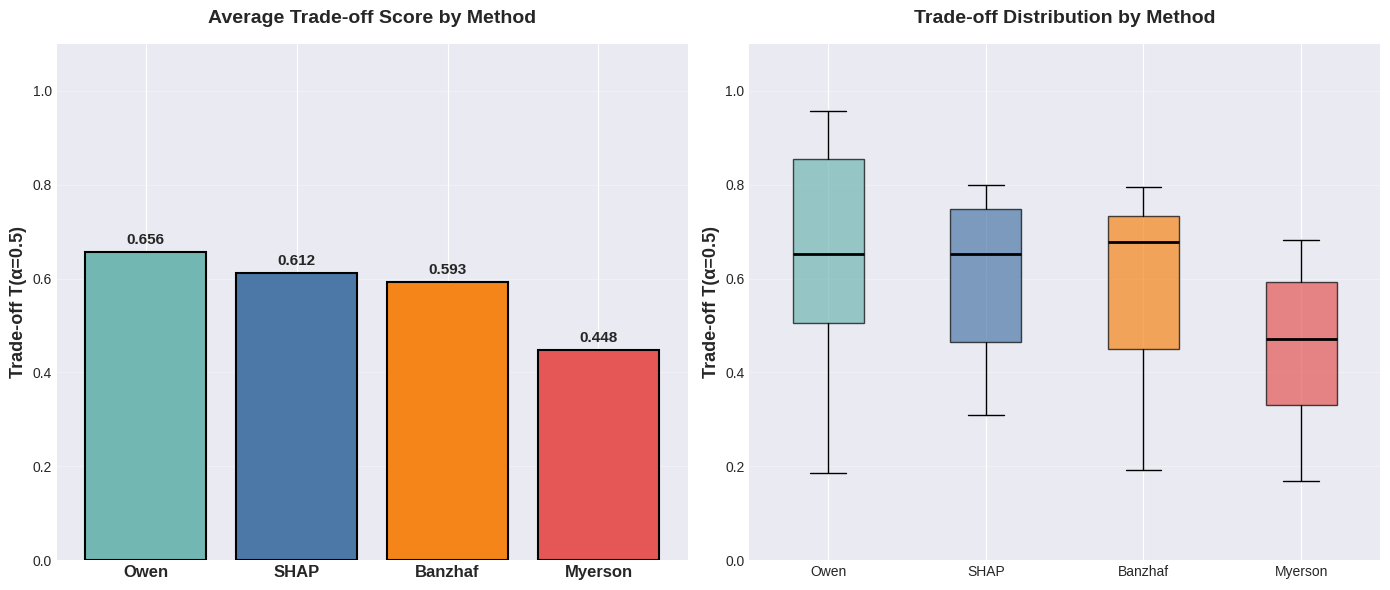


2. Generating AUC vs Interpretability Scatter...


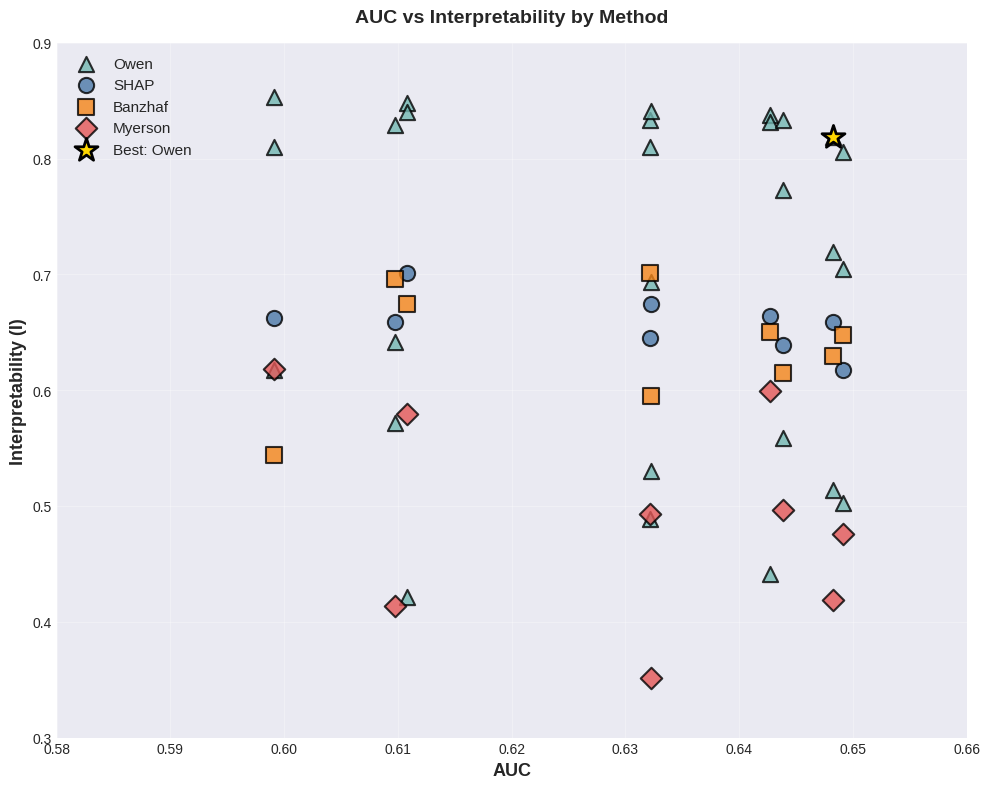


3. Generating Interpretability Components...


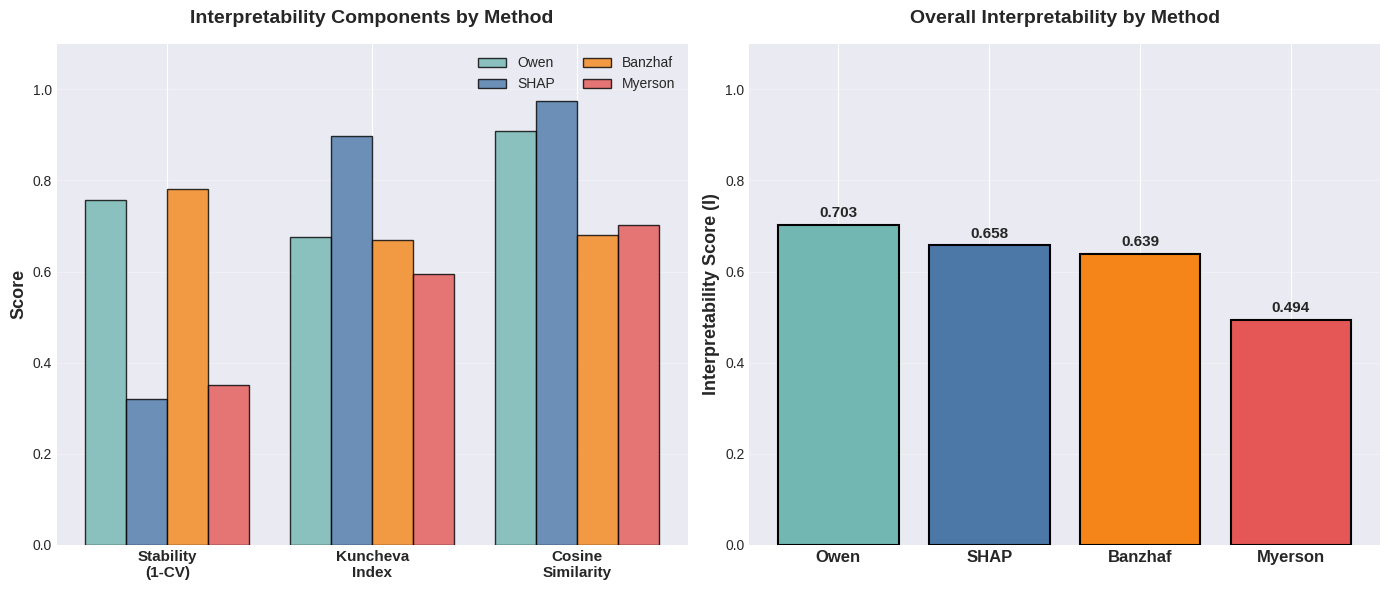


4. Generating Owen Grouping Strategies...


<Figure size 1200x800 with 0 Axes>

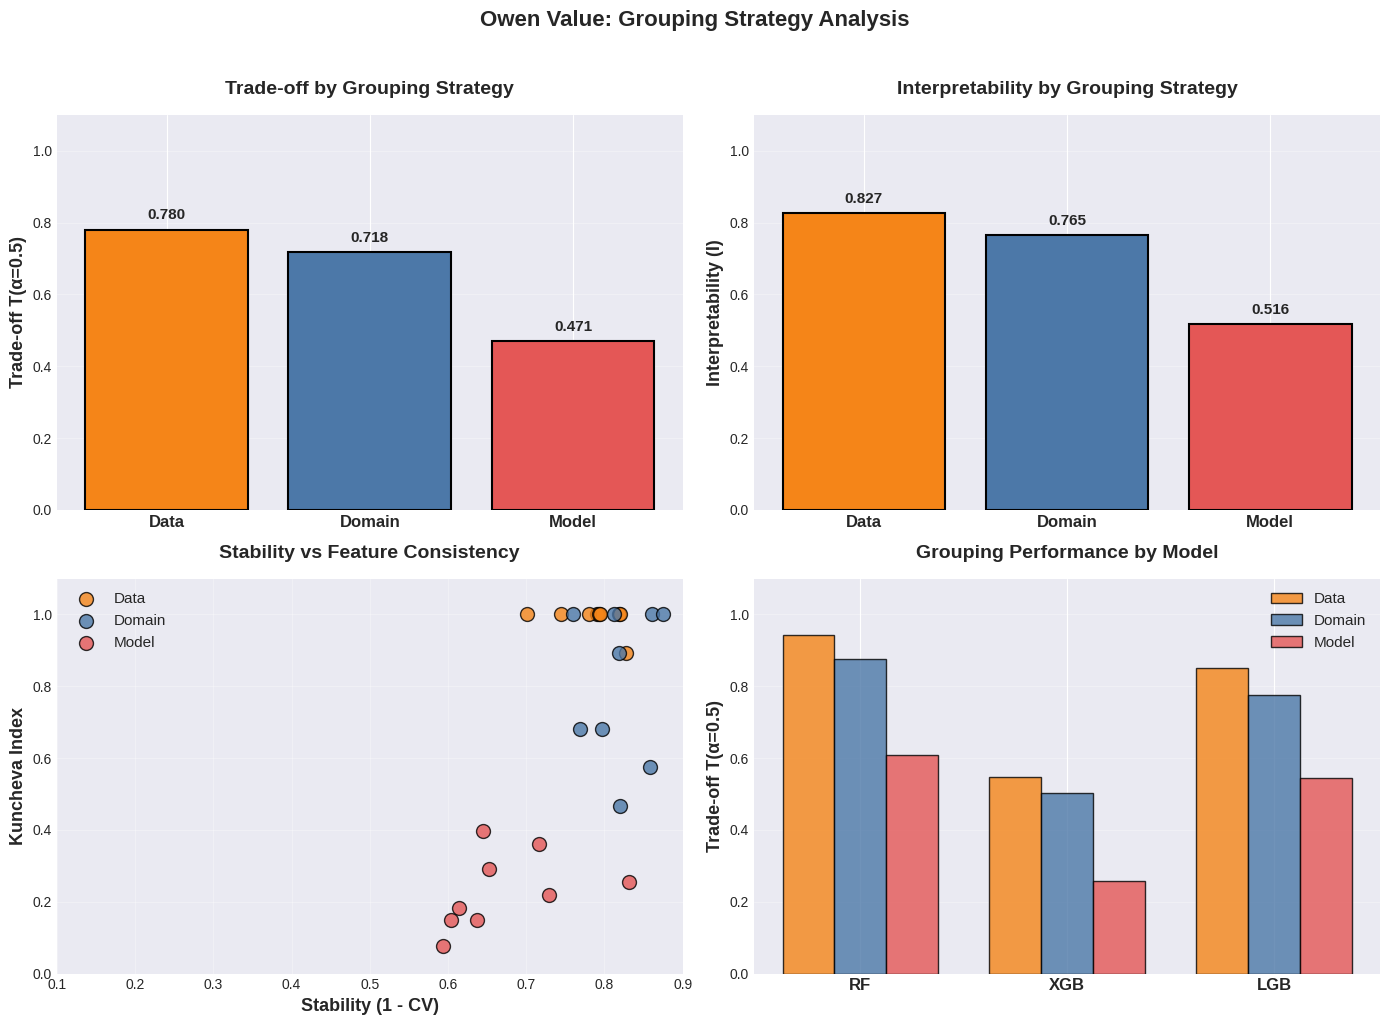


5. Generating Top Configurations...


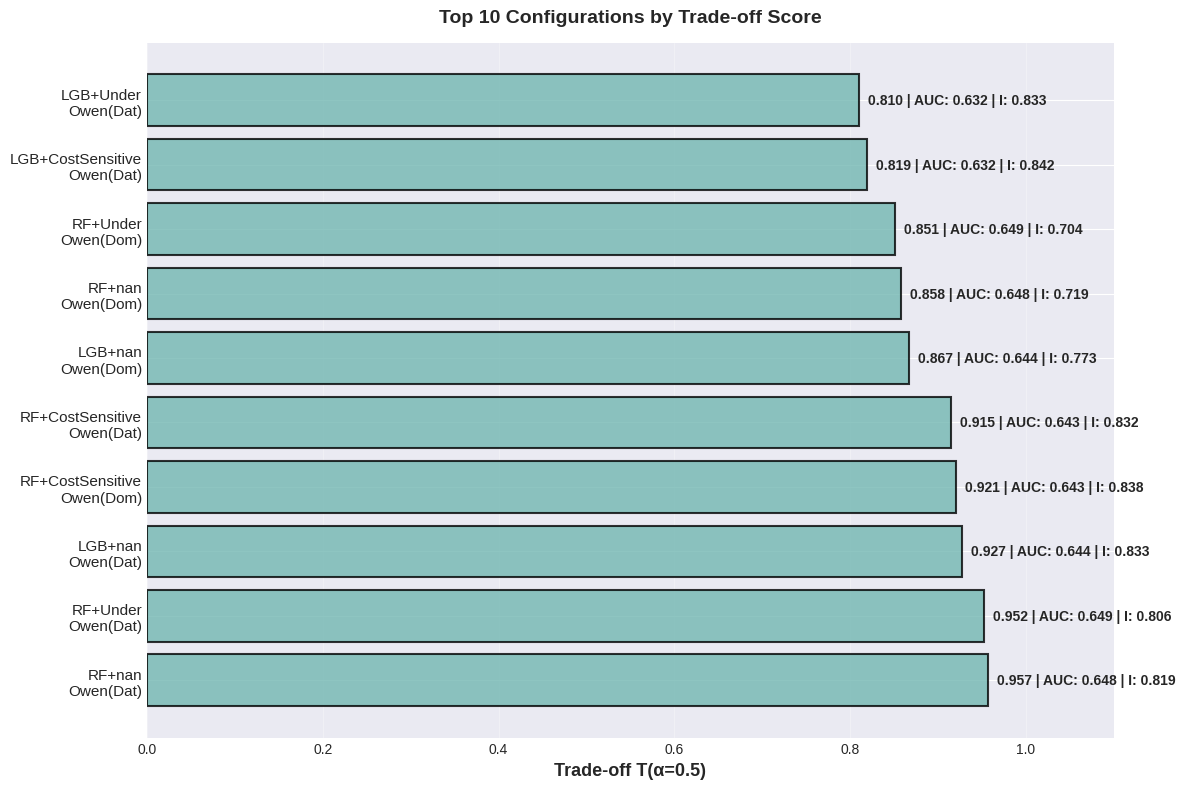


VISUALIZATIONS COMPLETE!

Generated files:
1. tradeoff_by_method.png - Main comparison of methods
2. auc_vs_interpretability.png - Scatter plot with best configuration
3. interpretability_components.png - Detailed interpretability analysis
4. owen_grouping_analysis.png - Owen grouping strategies (if available)
5. top_configurations.png - Best performing configurations

These 5 plots capture the most important findings from your analysis!


In [4]:
# ============================================================
# SIMPLIFIED VISUALIZATIONS FOR GAME THEORY EXPLAINABILITY
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Color schemes
method_colors = {
    'SHAP': '#4C78A8',      # Blue
    'Banzhaf': '#F58518',    # Orange
    'Myerson': '#E45756',    # Red
    'Owen': '#72B7B2'        # Teal
}

# Load data
metrics = pd.read_csv('complete_results.csv')
print(f"Loaded {len(metrics)} results")

# ============================================================
# PLOT 1: Trade-off Score by Method
# ============================================================
print("\n1. Generating Trade-off Score by Method...")

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart of average trade-off
method_means = metrics.groupby('Method')['T(α=0.5)'].mean().sort_values(ascending=False)
methods_sorted = method_means.index.tolist()

bars = ax1.bar(range(len(methods_sorted)), method_means.values,
              color=[method_colors.get(m, '#999999') for m in methods_sorted],
              edgecolor='black', linewidth=1.5)

# Add value labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax1.set_xticks(range(len(methods_sorted)))
ax1.set_xticklabels(methods_sorted, fontsize=12, fontweight='bold')
ax1.set_ylabel('Trade-off T(α=0.5)', fontsize=13, fontweight='bold')
ax1.set_title('Average Trade-off Score by Method', fontsize=14, fontweight='bold', pad=15)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 1.1)

# Box plot of trade-off distribution
box_data = [metrics[metrics['Method'] == m]['T(α=0.5)'].values for m in methods_sorted]
box = ax2.boxplot(box_data, labels=methods_sorted, patch_artist=True,
                 medianprops=dict(color='black', linewidth=2))

# Color the boxes
for i, patch in enumerate(box['boxes']):
    patch.set_facecolor(method_colors.get(methods_sorted[i], '#999999'))
    patch.set_alpha(0.7)

ax2.set_ylabel('Trade-off T(α=0.5)', fontsize=13, fontweight='bold')
ax2.set_title('Trade-off Distribution by Method', fontsize=14, fontweight='bold', pad=15)
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, 1.1)

plt.tight_layout()
plt.savefig('tradeoff_by_method.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================
# PLOT 2: AUC vs Interpretability Scatter
# ============================================================
print("\n2. Generating AUC vs Interpretability Scatter...")

plt.figure(figsize=(10, 8))

for method in methods_sorted:
    method_data = metrics[metrics['Method'] == method]
    plt.scatter(method_data['AUC'], method_data['I'],
               s=120, alpha=0.8, label=method,
               color=method_colors.get(method, '#999999'),
               edgecolors='black', linewidth=1.5,
               marker='o' if method == 'SHAP' else 's' if method == 'Banzhaf' else 'D' if method == 'Myerson' else '^')

plt.xlabel('AUC', fontsize=13, fontweight='bold')
plt.ylabel('Interpretability (I)', fontsize=13, fontweight='bold')
plt.title('AUC vs Interpretability by Method', fontsize=14, fontweight='bold', pad=15)
plt.legend(fontsize=11, loc='upper left')
plt.grid(alpha=0.3)
plt.xlim(0.58, 0.66)
plt.ylim(0.3, 0.9)

# Add best configuration point
best_idx = metrics['T(α=0.5)'].idxmax()
best_config = metrics.loc[best_idx]
plt.scatter(best_config['AUC'], best_config['I'],
           s=300, color='gold', edgecolors='black', linewidth=2,
           marker='*', zorder=5, label=f"Best: {best_config['Method']}")

plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig('auc_vs_interpretability.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================
# PLOT 3: Interpretability Components by Method
# ============================================================
print("\n3. Generating Interpretability Components...")

fig3, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart of interpretability components
components = ['Stability', 'Kuncheva', 'Cosine']
x = np.arange(len(components))
width = 0.2

for idx, method in enumerate(methods_sorted):
    method_data = metrics[metrics['Method'] == method]
    means = [method_data[comp].mean() for comp in components]
    offset = (idx - 1.5) * width

    ax1.bar(x + offset, means, width,
           color=method_colors.get(method, '#999999'),
           edgecolor='black', linewidth=1,
           label=method, alpha=0.8)

ax1.set_xticks(x)
ax1.set_xticklabels(['Stability\n(1-CV)', 'Kuncheva\nIndex', 'Cosine\nSimilarity'],
                   fontsize=11, fontweight='bold')
ax1.set_ylabel('Score', fontsize=13, fontweight='bold')
ax1.set_title('Interpretability Components by Method', fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=10, ncol=2)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 1.1)

# Overall Interpretability Score
interpretability_means = metrics.groupby('Method')['I'].mean().reindex(methods_sorted)

bars = ax2.bar(range(len(methods_sorted)), interpretability_means.values,
              color=[method_colors.get(m, '#999999') for m in methods_sorted],
              edgecolor='black', linewidth=1.5)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2.set_xticks(range(len(methods_sorted)))
ax2.set_xticklabels(methods_sorted, fontsize=12, fontweight='bold')
ax2.set_ylabel('Interpretability Score (I)', fontsize=13, fontweight='bold')
ax2.set_title('Overall Interpretability by Method', fontsize=14, fontweight='bold', pad=15)
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, 1.1)

plt.tight_layout()
plt.savefig('interpretability_components.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================
# PLOT 4: Owen Grouping Strategies
# ============================================================
print("\n4. Generating Owen Grouping Strategies...")

owen_data = metrics[metrics['Method'] == 'Owen']
if 'Grouping' in owen_data.columns and len(owen_data['Grouping'].unique()) > 1:
    plt.figure(figsize=(12, 8))

    groupings = owen_data['Grouping'].unique()
    grouping_colors = {'Domain': '#4C78A8', 'Data': '#F58518', 'Model': '#E45756'}

    # Create subplots
    fig4, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 4A. Trade-off by grouping
    ax1 = axes[0, 0]
    grouping_tradeoff = owen_data.groupby('Grouping')['T(α=0.5)'].mean().sort_values(ascending=False)
    groupings_sorted = grouping_tradeoff.index.tolist()

    bars = ax1.bar(range(len(groupings_sorted)), grouping_tradeoff.values,
                  color=[grouping_colors.get(g, '#999999') for g in groupings_sorted],
                  edgecolor='black', linewidth=1.5)

    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

    ax1.set_xticks(range(len(groupings_sorted)))
    ax1.set_xticklabels(groupings_sorted, fontsize=12, fontweight='bold')
    ax1.set_ylabel('Trade-off T(α=0.5)', fontsize=13, fontweight='bold')
    ax1.set_title('Trade-off by Grouping Strategy', fontsize=14, fontweight='bold', pad=15)
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_ylim(0, 1.1)

    # 4B. Interpretability by grouping
    ax2 = axes[0, 1]
    grouping_I = owen_data.groupby('Grouping')['I'].mean().reindex(groupings_sorted)

    bars = ax2.bar(range(len(groupings_sorted)), grouping_I.values,
                  color=[grouping_colors.get(g, '#999999') for g in groupings_sorted],
                  edgecolor='black', linewidth=1.5)

    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

    ax2.set_xticks(range(len(groupings_sorted)))
    ax2.set_xticklabels(groupings_sorted, fontsize=12, fontweight='bold')
    ax2.set_ylabel('Interpretability (I)', fontsize=13, fontweight='bold')
    ax2.set_title('Interpretability by Grouping Strategy', fontsize=14, fontweight='bold', pad=15)
    ax2.grid(axis='y', alpha=0.3)
    ax2.set_ylim(0, 1.1)

    # 4C. Stability vs Kuncheva
    ax3 = axes[1, 0]

    for grouping in groupings_sorted:
        group_data = owen_data[owen_data['Grouping'] == grouping]
        ax3.scatter(group_data['Stability'], group_data['Kuncheva'],
                   s=100, alpha=0.8, label=grouping,
                   color=grouping_colors.get(grouping, '#999999'),
                   edgecolors='black', linewidth=1)

    ax3.set_xlabel('Stability (1 - CV)', fontsize=13, fontweight='bold')
    ax3.set_ylabel('Kuncheva Index', fontsize=13, fontweight='bold')
    ax3.set_title('Stability vs Feature Consistency', fontsize=14, fontweight='bold', pad=15)
    ax3.legend(fontsize=11)
    ax3.grid(alpha=0.3)
    ax3.set_xlim(0.1, 0.9)
    ax3.set_ylim(0, 1.1)

    # 4D. Performance by model
    ax4 = axes[1, 1]

    models = ['RF', 'XGB', 'LGB']
    x = np.arange(len(models))
    width = 0.25

    for idx, grouping in enumerate(groupings_sorted[:3]):  # Top 3 groupings
        group_data = owen_data[owen_data['Grouping'] == grouping]
        means = []
        for model in models:
            model_data = group_data[group_data['Model'] == model]
            if len(model_data) > 0:
                means.append(model_data['T(α=0.5)'].mean())
            else:
                means.append(np.nan)

        ax4.bar(x + (idx - 1) * width, means, width,
               color=grouping_colors.get(grouping, '#999999'),
               edgecolor='black', linewidth=1,
               label=grouping, alpha=0.8)

    ax4.set_xticks(x)
    ax4.set_xticklabels(models, fontsize=12, fontweight='bold')
    ax4.set_ylabel('Trade-off T(α=0.5)', fontsize=13, fontweight='bold')
    ax4.set_title('Grouping Performance by Model', fontsize=14, fontweight='bold', pad=15)
    ax4.legend(fontsize=11)
    ax4.grid(axis='y', alpha=0.3)
    ax4.set_ylim(0, 1.1)

    plt.suptitle('Owen Value: Grouping Strategy Analysis',
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('owen_grouping_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================
# PLOT 5: Top Configurations
# ============================================================
print("\n5. Generating Top Configurations...")

plt.figure(figsize=(12, 8))

# Get top 10 configurations
top10 = metrics.nlargest(10, 'T(α=0.5)')

# Create labels
labels = []
colors = []
for _, row in top10.iterrows():
    label = f"{row.Model}+{row.Sampler}\n{row.Method}"
    if pd.notna(row.Grouping) and row.Grouping != 'None':
        label += f"({row.Grouping[:3]})"
    labels.append(label)
    colors.append(method_colors.get(row.Method, '#999999'))

# Create horizontal bar chart
y_pos = np.arange(len(top10))
plt.barh(y_pos, top10['T(α=0.5)'].values,
        color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)

plt.yticks(y_pos, labels, fontsize=11)
plt.xlabel('Trade-off T(α=0.5)', fontsize=13, fontweight='bold')
plt.title('Top 10 Configurations by Trade-off Score', fontsize=14, fontweight='bold', pad=15)
plt.grid(axis='x', alpha=0.3)
plt.xlim(0, 1.1)

# Add value labels
for i, (_, row) in enumerate(top10.iterrows()):
    plt.text(row['T(α=0.5)'] + 0.01, i,
            f"{row['T(α=0.5)']:.3f} | AUC: {row['AUC']:.3f} | I: {row['I']:.3f}",
            va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('top_configurations.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("VISUALIZATIONS COMPLETE!")
print("="*80)
print("\nGenerated files:")
print("1. tradeoff_by_method.png - Main comparison of methods")
print("2. auc_vs_interpretability.png - Scatter plot with best configuration")
print("3. interpretability_components.png - Detailed interpretability analysis")
print("4. owen_grouping_analysis.png - Owen grouping strategies (if available)")
print("5. top_configurations.png - Best performing configurations")
print("\nThese 5 plots capture the most important findings from your analysis!")